### Interpret Results: 1D Regression

In [1]:
from notebook_utils import modify_sys_path, get_parent_dir_path, set_plot_style

modify_sys_path()
set_plot_style()

#### Plotting Single Graph

In [2]:
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from src.utils import ToyRegressionUtils
from csaps import csaps

from src.utils import calculate_min_Va_by_KL_rank

In [ ]:
def get_results_df(results_directory, num_valid_Va: int=5, feature_column='x1') -> pd.DataFrame:

    # Load the results
    df_list = []
    for filename in os.listdir(get_parent_dir_path(results_directory)):
        if f"results_" in filename:# and f"seed_{seed}" in filename:
            save_data = pd.read_csv(get_parent_dir_path(results_directory) + filename)
            df_list.append(save_data)

    for save_data in df_list:
        # z_data = calculate_min_Va_by_KL_threshold(z_data, threshold=0.005, forward_kl=True)
        save_data = calculate_min_Va_by_KL_rank(save_data, num_valid_Va=num_valid_Va, forward_kl=True, upper_bound_by_total_U=True)
        save_data = calculate_min_Va_by_KL_rank(save_data, num_valid_Va=num_valid_Va, forward_kl=True, upper_bound_by_total_U=True, uncertainty_type="variance")


    x_x1_list = []
    total_uncertainty_list = []
    kl_pyx_pyxz_list = []
    kl_pyxz_pyx_list = []
    min_Va_list = []    
    max_Ve_list = []
    z_value_for_min_Va_list = []

    prob_y_xz_mean_list = []
    prob_y_xz_std_list = []
    prob_y_x_mean_list = []
    prob_y_x_std_list = []
    within_threshold_list = []

    total_variance_list = []
    min_Va_variance_list = []
    max_Ve_variance_list = []

    for z_df in df_list:
        try:
            x_x1 = z_df[f'x_{feature_column}'].values[0]
            x_x1_list.append(x_x1)
            total_uncertainty = z_df["H[p(y|x,D)]"].values[0]
            total_uncertainty_list.append(total_uncertainty)
            # index where z_value_for_min_Va is True
            min_Va_index = z_df[z_df["z_value_for_min_Va"]].index[0]
            z_value_for_min_Va_list.append(z_df[f"z_{feature_column}"].values[min_Va_index])
            
            # get the prob_y_xz and prob_y_x
            prob_y_x_mean = z_df["p(y|x,D)_mean"].values[min_Va_index]
            prob_y_x_std = z_df["p(y|x,D)_std"].values[min_Va_index]
            prob_y_xz_mean = z_df["p(y|x,z,D)_mean"].values[min_Va_index]
            prob_y_xz_std = z_df["p(y|x,z,D)_std"].values[min_Va_index]
            
            prob_y_x_mean_list.append(prob_y_x_mean)
            prob_y_x_std_list.append(prob_y_x_std)
            prob_y_xz_mean_list.append(prob_y_xz_mean)
            prob_y_xz_std_list.append(prob_y_xz_std)
            
            kl_pyx_pyxz = z_df["kl_pyx_pyxz"].values[min_Va_index]
            kl_pyx_pyxz_list.append(kl_pyx_pyxz)
            kl_pyxz_pyx = z_df["kl_pyxz_pyx"].values[min_Va_index]
            kl_pyxz_pyx_list.append(kl_pyxz_pyx)
            min_Va = z_df["min_Va"].values[0]
            min_Va_list.append(min_Va)
            max_Ve = z_df["max_Ve"].values[0]
            max_Ve_list.append(max_Ve)
            
            within_threshold_list.append(z_df[z_df["within_threshold"]][f"z_{feature_column}"].values)
            
        except:
            pass
        
        try:
            total_variance = z_df["Var[y|x,D]"].values[0]
            total_variance_list.append(total_variance)
            
            min_Va_variance = z_df["min_Va_variance"].values[0]
            min_Va_variance_list.append(min_Va_variance)   
            
            max_Ve_variance = z_df["max_Ve_variance"].values[0]
            max_Ve_variance_list.append(max_Ve_variance)
        except:
            pass     
            
        
    # Create a dataframe from the lists
    data = {f'x_{feature_column}': x_x1_list,
            'total_uncertainty': total_uncertainty_list,
            'min_Va': min_Va_list,
            'max_Ve': max_Ve_list,
            'kl_pyx_pyxz': kl_pyx_pyxz_list,
            'kl_pyxz_pyx': kl_pyxz_pyx_list,
            'z_value_for_min_Va': z_value_for_min_Va_list,
            'within_threshold': within_threshold_list,
            'prob_y_xz_mean': prob_y_xz_mean_list,
            'prob_y_xz_std': prob_y_xz_std_list,
            'prob_y_x_mean': prob_y_x_mean_list,
            'prob_y_x_std': prob_y_x_std_list,
            }

    if len(total_variance_list) > 0:
        data['total_variance'] = total_variance_list
        data['min_Va_variance'] = min_Va_variance_list
        data['max_Ve_variance'] = max_Ve_variance_list

    num_Va = len(min_Va_list)

    # reduce the length of list to the number of num_Va
    for key in data.keys():
        data[key] = data[key][:num_Va]

    results_df = pd.DataFrame(data)

    results_df = results_df.sort_values(by=f'x_{feature_column}')
    
    return results_df

In [30]:
def get_average_results_df(results_directories: list[str], seeds: list[int], num_valid_Va: int=5, feature_column='x1') -> pd.DataFrame:
    
    # Load the results
    df_list = []
    for seed, results_directory in zip(seeds, results_directories):
        for filename in os.listdir(get_parent_dir_path(results_directory)):
            if f"results_" in filename:
                save_data = pd.read_csv(get_parent_dir_path(results_directory) + filename)
                save_data["seed"] = seed
                df_list.append(save_data)
                
    for save_data in df_list:
        # z_data = calculate_min_Va_by_KL_threshold(z_data, threshold=0.005, forward_kl=True)
        save_data = calculate_min_Va_by_KL_rank(save_data, num_valid_Va=num_valid_Va, forward_kl=True, upper_bound_by_total_U=True)
        save_data = calculate_min_Va_by_KL_rank(save_data, num_valid_Va=num_valid_Va, forward_kl=True, upper_bound_by_total_U=True, uncertainty_type="variance")
                

    x_x1_list = []
    total_uncertainty_list = []
    kl_pyx_pyxz_list = []
    kl_pyxz_pyx_list = []
    min_Va_list = []    
    max_Ve_list = []
    z_value_for_min_Va_list = []

    prob_y_xz_mean_list = []
    prob_y_xz_std_list = []
    prob_y_x_mean_list = []
    prob_y_x_std_list = []
    within_threshold_list = []

    total_variance_list = []
    min_Va_variance_list = []
    max_Ve_variance_list = []
    seed_list = []

    for z_df in df_list:
        try:
            x_x1 = z_df[f'x_{feature_column}'].values[0]
            x_x1_list.append(x_x1)
            total_uncertainty = z_df["H[p(y|x,D)]"].values[0]
            total_uncertainty_list.append(total_uncertainty)
            # index where z_value_for_min_Va is True
            min_Va_index = z_df[z_df["z_value_for_min_Va"]].index[0]
            z_value_for_min_Va_list.append(z_df[f"z_{feature_column}"].values[min_Va_index])
            
            # get the prob_y_xz and prob_y_x
            prob_y_x_mean = z_df["p(y|x,D)_mean"].values[min_Va_index]
            prob_y_x_std = z_df["p(y|x,D)_std"].values[min_Va_index]
            prob_y_xz_mean = z_df["p(y|x,z,D)_mean"].values[min_Va_index]
            prob_y_xz_std = z_df["p(y|x,z,D)_std"].values[min_Va_index]
            
            prob_y_x_mean_list.append(prob_y_x_mean)
            prob_y_x_std_list.append(prob_y_x_std)
            prob_y_xz_mean_list.append(prob_y_xz_mean)
            prob_y_xz_std_list.append(prob_y_xz_std)
            
            kl_pyx_pyxz = z_df["kl_pyx_pyxz"].values[min_Va_index]
            kl_pyx_pyxz_list.append(kl_pyx_pyxz)
            kl_pyxz_pyx = z_df["kl_pyxz_pyx"].values[min_Va_index]
            kl_pyxz_pyx_list.append(kl_pyxz_pyx)
            min_Va = z_df["min_Va"].values[0]
            min_Va_list.append(min_Va)
            max_Ve = z_df["max_Ve"].values[0]
            max_Ve_list.append(max_Ve)
            
            within_threshold_list.append(z_df[z_df["within_threshold"]][f"z_{feature_column}"].values)
            
            seed_list.append(z_df["seed"].values[0])
            
        except:
            pass
        
        try:
            total_variance = z_df["Var[y|x,D]"].values[0]
            total_variance_list.append(total_variance)
            
            min_Va_variance = z_df["min_Va_variance"].values[0]
            min_Va_variance_list.append(min_Va_variance)   
            
            max_Ve_variance = z_df["max_Ve_variance"].values[0]
            max_Ve_variance_list.append(max_Ve_variance)
        except:
            pass     
            
        
    # Create a dataframe from the lists
    data = {f'x_{feature_column}': x_x1_list,
            'total_uncertainty': total_uncertainty_list,
            'min_Va': min_Va_list,
            'max_Ve': max_Ve_list,
            'kl_pyx_pyxz': kl_pyx_pyxz_list,
            'kl_pyxz_pyx': kl_pyxz_pyx_list,
            'z_value_for_min_Va': z_value_for_min_Va_list,
            'within_threshold': within_threshold_list,
            'prob_y_xz_mean': prob_y_xz_mean_list,
            'prob_y_xz_std': prob_y_xz_std_list,
            'prob_y_x_mean': prob_y_x_mean_list,
            'prob_y_x_std': prob_y_x_std_list,
            'seed': seed_list,
            }

    if len(total_variance_list) > 0:
        data['total_variance'] = total_variance_list
        data['min_Va_variance'] = min_Va_variance_list
        data['max_Ve_variance'] = max_Ve_variance_list

    num_Va = len(min_Va_list)

    # reduce the length of list to the number of num_Va
    for key in data.keys():
        data[key] = data[key][:num_Va]

    results_df = pd.DataFrame(data)

    results_df = results_df.sort_values(by=f'x_{feature_column}')

    results_df = results_df[(results_df["min_Va"] != -np.inf)]

    average_results_df = results_df.groupby(f'x_{feature_column}').mean().reset_index()
    
    return average_results_df

### Plot Single Decomposition

##### Parameters (EDIT cell below)

In [33]:
RESULTS_DIRECTORY = f'results/toy_regression/gaps/experiment_1/'

In [ ]:
### Run this cell

D_data = None

for filename in os.listdir(get_parent_dir_path(RESULTS_DIRECTORY)):
    if f"D_" in filename:# and f"seed_{seed}" in filename:
        D_data = pd.read_csv(get_parent_dir_path(RESULTS_DIRECTORY) + filename)
        
feature_column = ToyRegressionUtils.get_feature_columns(D_data)[0]

results_df = get_results_df(RESULTS_DIRECTORY, num_valid_Va=5, feature_column=feature_column)
results_df = results_df[(results_df["min_Va"] != -np.inf)]
valid_va = (results_df["min_Va"] != -np.inf)

##### Total Uncertainty Decomposition

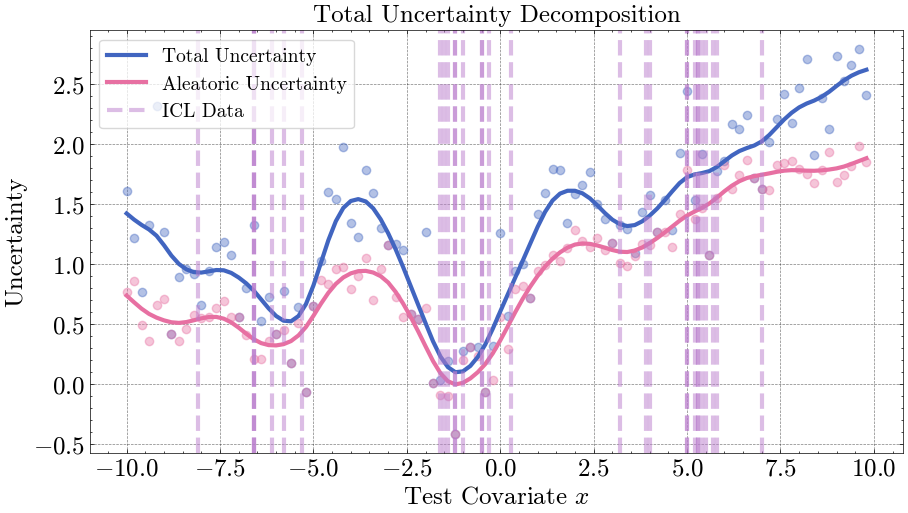

In [ ]:
plt.figure(figsize=(10.5, 5.5))

x_grid = np.linspace(results_df[f'x_{feature_column}'].min(), results_df[f'x_{feature_column}'].max(), 100)
y_total_uncertainty = csaps(results_df[f'x_{feature_column}'], results_df['total_uncertainty'], smooth=0.85)
y_min_Va = csaps(results_df.loc[valid_va, f'x_{feature_column}'], results_df.loc[valid_va, 'min_Va'], smooth=0.85)


plt.scatter(results_df[f'x_{feature_column}'], results_df['total_uncertainty'], color='C0', alpha=0.4)
plt.scatter(results_df[f'x_{feature_column}'], results_df['min_Va'], color = 'C1', alpha=0.4)
plt.plot(x_grid, y_total_uncertainty(x_grid), color='C0', linewidth=3, label='Total Uncertainty')
plt.plot(x_grid, y_min_Va(x_grid), color='C1', linewidth=3, label='Aleatoric Uncertainty')


# vertical line for the true x
label_seen = False
for i, row in D_data.iterrows():
    if not label_seen:
        label_seen = True
        label_string = 'ICL Data'
    else:
        label_string = None
    plt.axvline(x=row[feature_column], color='C5', linestyle='--', alpha=0.5, linewidth=3, label=label_string)

plt.title("Total Uncertainty Decomposition")
plt.ylabel('Uncertainty')
plt.xlabel(r'Test Covariate $x$')

plt.legend(framealpha=0.75)

plt.show()

##### Total Variance Decomposition

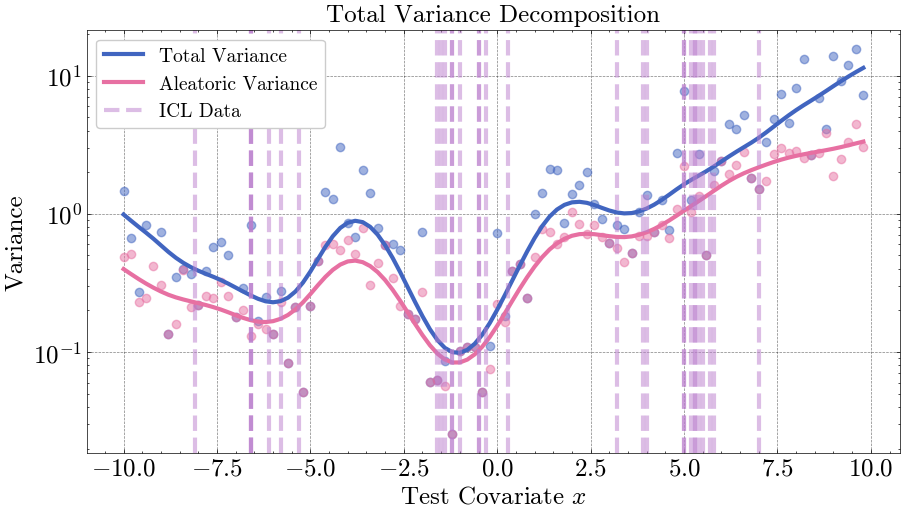

In [8]:
plt.figure(figsize=(10.5, 5.5))

x_grid = np.linspace(results_df[f'x_{feature_column}'].min(), results_df[f'x_{feature_column}'].max(), 100)
y_total_uncertainty = csaps(results_df[f'x_{feature_column}'], np.log(results_df['total_variance']), smooth=0.5)
y_min_Va = csaps(results_df[f'x_{feature_column}'], np.log(results_df['min_Va_variance']), smooth=0.5)

plt.scatter(results_df[f'x_{feature_column}'], results_df['total_variance'], color='C0', alpha=0.5)
plt.scatter(results_df[f'x_{feature_column}'], results_df['min_Va_variance'], color='C1', alpha=0.5)
plt.plot(x_grid, np.exp(y_total_uncertainty(x_grid)), color='C0', linewidth=3, label='Total Variance')
plt.plot(x_grid, np.exp(y_min_Va(x_grid)), color='C1', linewidth=3, label='Aleatoric Variance')

# vertical line for the true x
label_seen = False
for i, row in D_data.iterrows():
    if not label_seen:
        label_seen = True
        label_string = 'ICL Data'
    else:
        label_string = None
    plt.axvline(x=row[feature_column], color='C5', linestyle='--', alpha=0.5, linewidth=3, label=label_string)

plt.title("Total Variance Decomposition")
plt.yscale('log')
plt.ylabel('Variance')

plt.legend()

plt.xlabel(r'Test Covariate $x$')

plt.show()

##### Predicted Mean and Standard Deviation

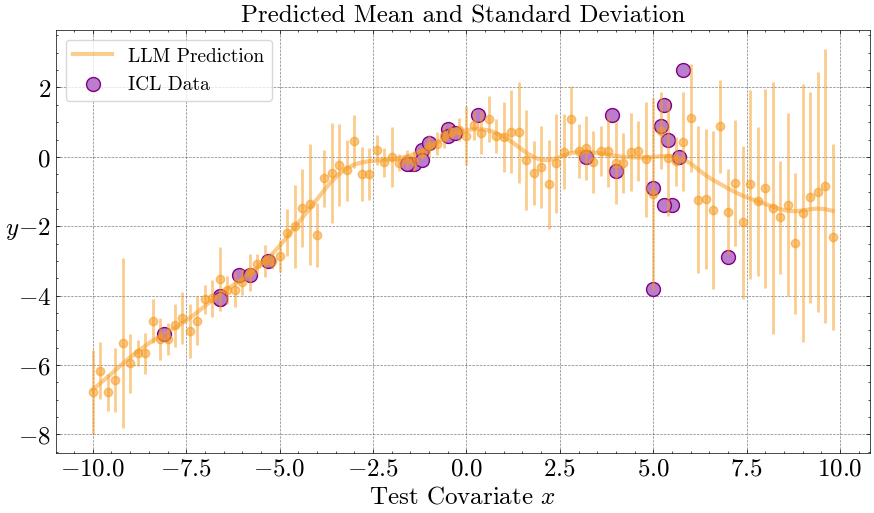

In [9]:
plt.figure(figsize=(10.5, 5.5))

x_grid = np.linspace(results_df[f'x_{feature_column}'].min(), results_df[f'x_{feature_column}'].max(), 100)
y_mean = csaps(results_df[f'x_{feature_column}'], results_df['prob_y_x_mean'], smooth=0.85)

plt.plot(x_grid, y_mean(x_grid), color='C4', linewidth=3, label="LLM Prediction", alpha=0.5)


label_seen = False
for i, row in D_data.iterrows():
    if not label_seen:
        label_seen = True
        label_string = 'ICL Data'
    else:
        label_string = None
    plt.scatter(row[feature_column], row['label'], color='C5', edgecolor='purple', alpha=1, label=label_string, s=100)

plt.scatter(results_df[f'x_{feature_column}'], results_df['prob_y_x_mean'], color='C4', alpha=0.05)
plt.errorbar(results_df[f'x_{feature_column}'], results_df['prob_y_x_mean'], yerr=results_df['prob_y_x_std'], linewidth=2, fmt='o', color='C4', alpha=0.5)
    
plt.title("Predicted Mean and Standard Deviation")

plt.xlabel(r'Test Covariate $x$')
plt.ylabel(r'$y$', rotation=0)
    
plt.legend(framealpha=0.75)

plt.show()


### Plotting Graph Averaged Over Seeds

##### Parameters (EDIT cell below)

In [11]:

results_parent_directory = f'results/toy_regression/linear_regression/experiment_3/'

RESULTS_DIRECTORIES = [results_parent_directory + f'seed_{i}/' for i in range(3)]

SEEDS = [0, 1, 2]


In [31]:
### Run this cell

D_data_list = []

for results_directory in RESULTS_DIRECTORIES:
    for filename in os.listdir(get_parent_dir_path(results_directory)):
        if f"D_" in filename:
            D_data = pd.read_csv(get_parent_dir_path(results_directory) + filename)
            D_data_list.append(D_data)
        
concatenated_D_data = pd.concat(D_data_list, ignore_index=True).reset_index(drop=True)

feature_column = ToyRegressionUtils.get_feature_columns(concatenated_D_data)[0]
        
average_results_df = get_average_results_df(RESULTS_DIRECTORIES, SEEDS, num_valid_Va=5, feature_column=feature_column)

valid_va = (average_results_df["min_Va"] != -np.inf) & (average_results_df['min_Va'] > 0)

##### Total Uncertainty Decomposition

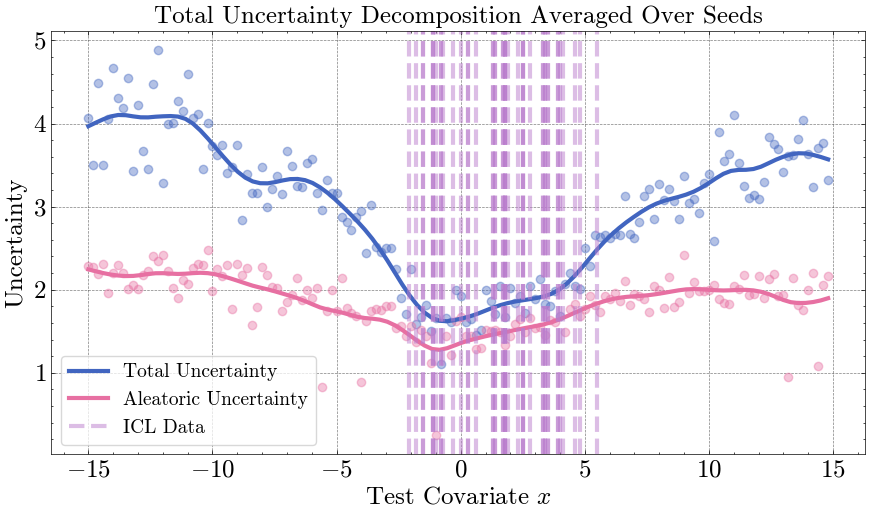

In [ ]:
plt.figure(figsize=(10.5, 5.5))

x_grid = np.linspace(average_results_df[f'x_{feature_column}'].min(), average_results_df[f'x_{feature_column}'].max(), 100)
y_total_uncertainty = csaps(average_results_df[f'x_{feature_column}'], average_results_df['total_uncertainty'], smooth=0.5)
y_min_Va = csaps(average_results_df.loc[valid_va, f'x_{feature_column}'], average_results_df.loc[valid_va, 'min_Va'], smooth=0.5)

plt.scatter(average_results_df[f'x_{feature_column}'], average_results_df['total_uncertainty'], color='C0', alpha=0.4)
plt.scatter(average_results_df.loc[valid_va,f'x_{feature_column}'], average_results_df.loc[valid_va,'min_Va'], color = 'C1', alpha=0.4)
plt.plot(x_grid, y_total_uncertainty(x_grid), color='C0', linewidth=3, label='Total Uncertainty')
plt.plot(x_grid, y_min_Va(x_grid), color='C1', linewidth=3, label='Aleatoric Uncertainty')

# vertical line for the true x
label_seen = False
for i, row in concatenated_D_data.iterrows():
    if not label_seen:
        label_seen = True
        label_string = 'ICL Data'
    else:
        label_string = None
    plt.axvline(x=row[feature_column], color='C5', linestyle='--', alpha=0.5, linewidth=3, label=label_string)

plt.title("Total Uncertainty Decomposition (Averaged Over Seeds)")
plt.ylabel('Uncertainty')
plt.xlabel(r'Test Covariate $x$')

plt.legend(framealpha=0.75)

plt.show()

##### Total Variance Decomposition

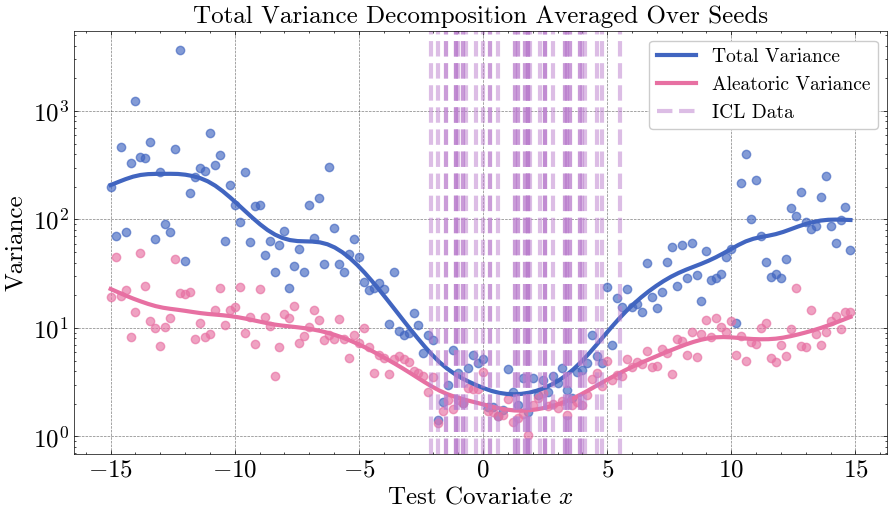

In [ ]:
fig, ax = plt.subplots(figsize=(10.5, 5.5))

x_grid = np.linspace(average_results_df[f'x_{feature_column}'].min(), average_results_df[f'x_{feature_column}'].max(), 100)
y_total_uncertainty = csaps(average_results_df[f'x_{feature_column}'], np.log(average_results_df['total_variance']), smooth=0.2)
y_min_Va = csaps(average_results_df[f'x_{feature_column}'], np.log(average_results_df['min_Va_variance']), smooth=0.2)

plt.scatter(average_results_df[f'x_{feature_column}'], average_results_df['total_variance'], color='C0', alpha=0.65)
plt.scatter(average_results_df[f'x_{feature_column}'], average_results_df['min_Va_variance'], color='C1', alpha=0.65)
plt.plot(x_grid, np.exp(y_total_uncertainty(x_grid)), color='C0', linewidth=3, label='Total Variance')
plt.plot(x_grid, np.exp(y_min_Va(x_grid)), color='C1', linewidth=3, label='Aleatoric Variance')

# vertical line for the true x
label_seen = False
for i, row in concatenated_D_data.iterrows():
    if not label_seen:
        label_seen = True
        label_string = 'ICL Data'
    else:
        label_string = None
    plt.axvline(x=row[feature_column], color='C5', linestyle='--', alpha=0.5, linewidth=3, label=label_string)

plt.title("Total Variance Decomposition (Averaged Over Seeds)")
plt.yscale('log')
plt.ylabel('Variance')

plt.legend()

plt.xlabel(r'Test Covariate $x$')

plt.show()

##### Predicted Mean and Standard Deviation

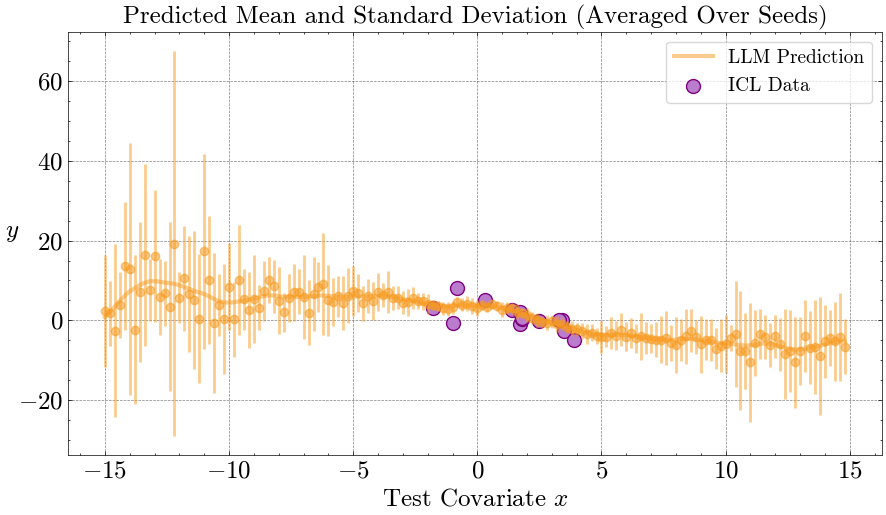

In [29]:
plt.figure(figsize=(10.5, 5.5))

x_grid = np.linspace(average_results_df[f'x_{feature_column}'].min(), average_results_df[f'x_{feature_column}'].max(), 100)
y_mean = csaps(average_results_df[f'x_{feature_column}'], average_results_df['prob_y_x_mean'], smooth=0.85)

plt.plot(x_grid, y_mean(x_grid), color='C4', linewidth=3, label="LLM Prediction", alpha=0.5)


label_seen = False
for i, row in D_data.iterrows():
    if not label_seen:
        label_seen = True
        label_string = 'ICL Data'
    else:
        label_string = None
    plt.scatter(row[feature_column], row['label'], color='C5', edgecolor='purple', alpha=1, label=label_string, s=100)

plt.scatter(average_results_df[f'x_{feature_column}'], average_results_df['prob_y_x_mean'], color='C4', alpha=0.05)
plt.errorbar(average_results_df[f'x_{feature_column}'], average_results_df['prob_y_x_mean'], yerr=average_results_df['prob_y_x_std'], linewidth=2, fmt='o', color='C4', alpha=0.5)

    
plt.title("Predicted Mean and Standard Deviation (Averaged Over Seeds)")

plt.xlabel(r'Test Covariate $x$')
plt.ylabel(r'$y$', rotation=0)
    
plt.legend(framealpha=0.75)

plt.show()
